<a href="https://colab.research.google.com/github/An210/ML/blob/main/Large%20Holders%20Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

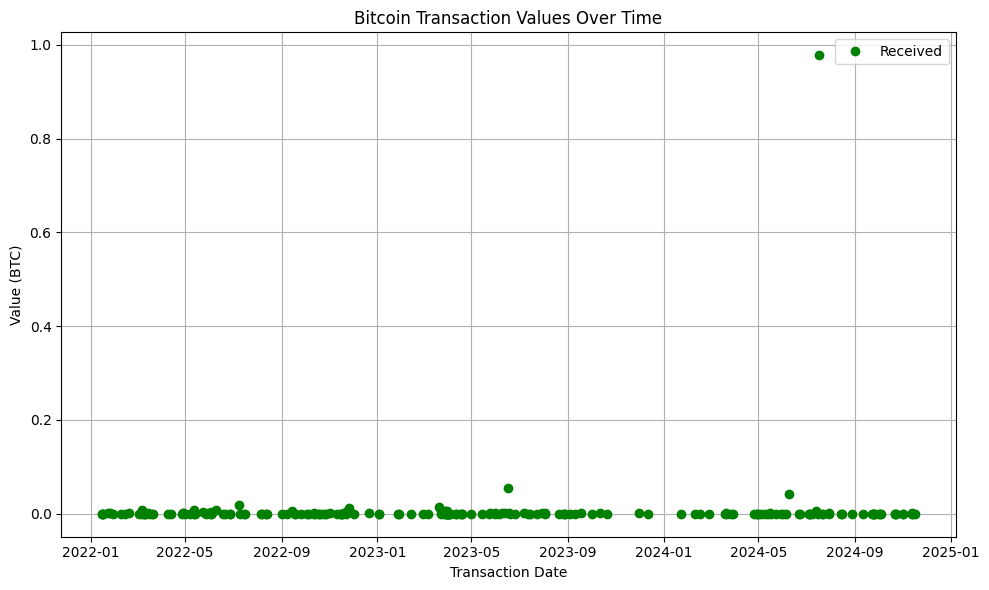

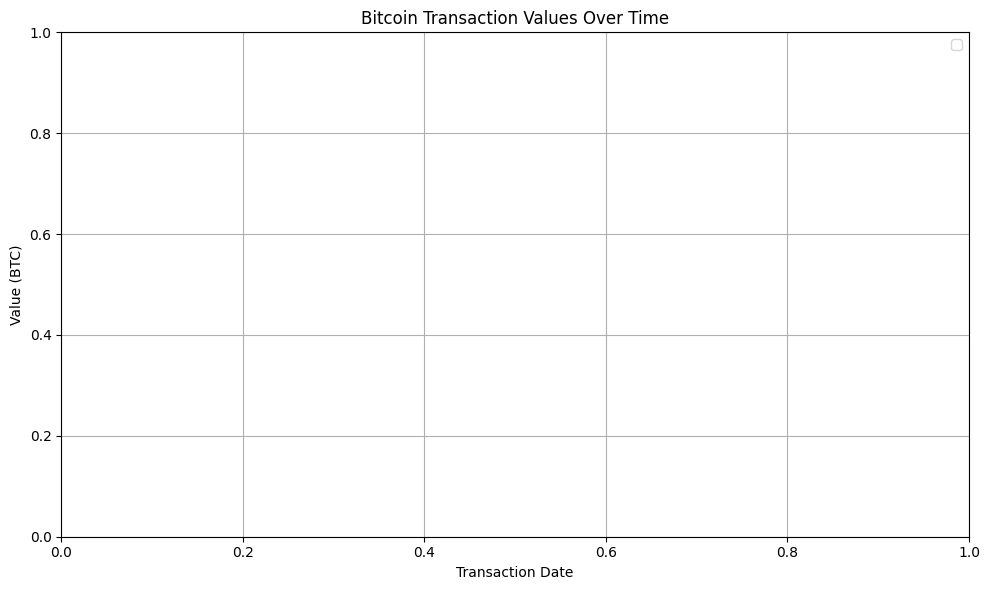

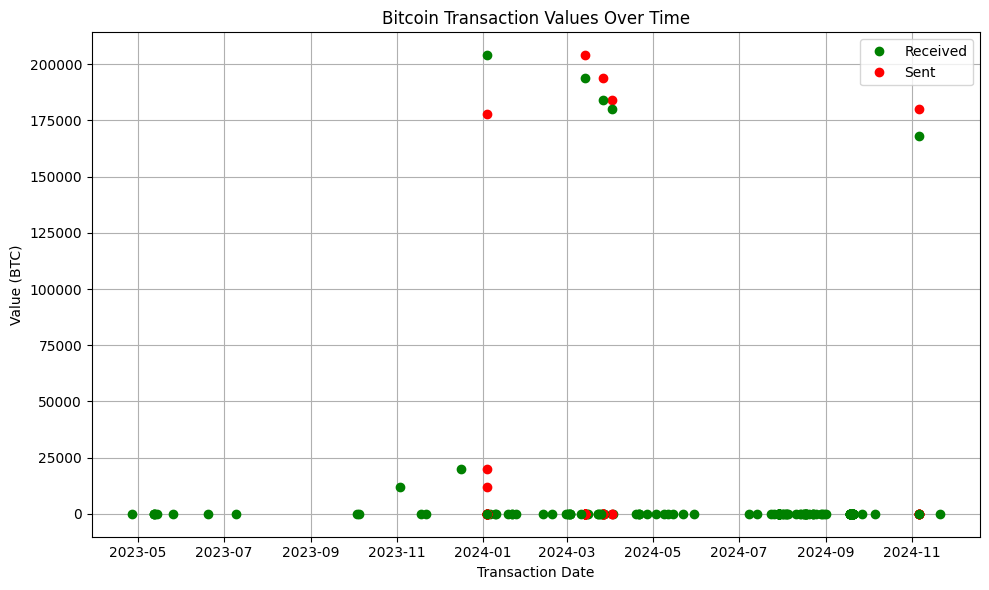

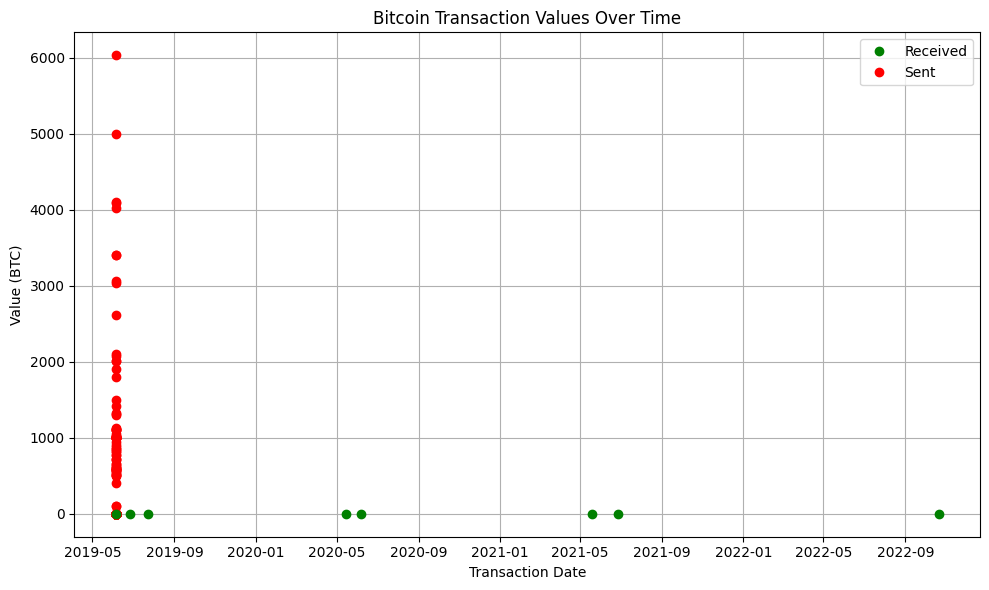

In [8]:
# Install the required libraries
!pip install blockcypher matplotlib

# Import the necessary modules
import blockcypher
import matplotlib.pyplot as plt
from datetime import datetime
import time  # Import the time module for sleep functionality

# Replace with the Bitcoin address you want to observe
bitcoin_addresses = [
        {'address': 'bc1qxy2kgdygjrsqtzq2n0yrf2493p83kkfjhx0wlh', 'company': 'Binance Cold Wallet'},
        {'address': 'bc1qw508d6qejxtdg4y5r3zarvary0c5xw7kygt080', 'company': 'Bitfinex Cold Wallet'},
        {'address': 'bc1qgdjqv0av3q56jvd82tkdjpy7gdp9ut8tlqmgrpmv24sq90ecnvqqjwvw97', 'company': 'Robinhood'},
        {'address': '3Cbq7aT1tY8kMxWLbitaG7yT6bPbKChq64', 'company': 'Coinbase Cold Wallet'},

    ]

def helper(bitcoin_address):
  # Get the address details
  address_details = blockcypher.get_address_details(bitcoin_address)

  # Get the last 10 transactions
  last_10_transactions = address_details.get('txrefs', [])[:500]

  # Reverse the transaction list to sort by earliest to latest
  last_10_transactions = list(last_10_transactions)

  # Prepare data for plotting
  dates = []
  values = []
  transaction_types = []  # List to store transaction types (Sent/Received)

  for tx in last_10_transactions:
      tx_date = tx['confirmed']  # Get the confirmation date
      tx_value = tx['value'] / 1e8    # Get the transaction value
      tx_type = "Sent" if tx['tx_input_n'] >= 0 else "Received"  # Determine if sent or received

      # Check if the date is a datetime object
      if isinstance(tx_date, str):
          # Convert string to datetime object
          dates.append(datetime.strptime(tx_date, "%Y-%m-%dT%H:%M:%S"))
      else:
          # If it's already a datetime object, append directly
          dates.append(tx_date)

      values.append(tx_value)
      transaction_types.append(tx_type)  # Append the type of transaction

  # Plot the data
  plt.figure(figsize=(10, 6))

  # Plot Sent transactions in red and Received transactions in green
  for i, tx_type in enumerate(transaction_types):
      if tx_type == "Sent":
          plt.plot(dates[i], values[i], marker='o', color='red', linestyle=' ', label='Sent' )
      else:
          plt.plot(dates[i], values[i], marker='o', color='green', linestyle=' ', label='Received')

  plt.title('Bitcoin Transaction Values Over Time')
  plt.xlabel('Transaction Date')
  plt.ylabel('Value (BTC)')
  plt.grid(True)

  # Add legend with unique entries
  handles, labels = plt.gca().get_legend_handles_labels()
  by_label = dict(zip(labels, handles))  # Remove duplicates
  plt.legend(by_label.values(), by_label.keys())

  # Display the plot
  plt.tight_layout()
  plt.show()
  print('===============================')
  time.sleep(5) # Pause for 7 seconds before the next API call

for ea in bitcoin_addresses:
  helper(ea['address'])


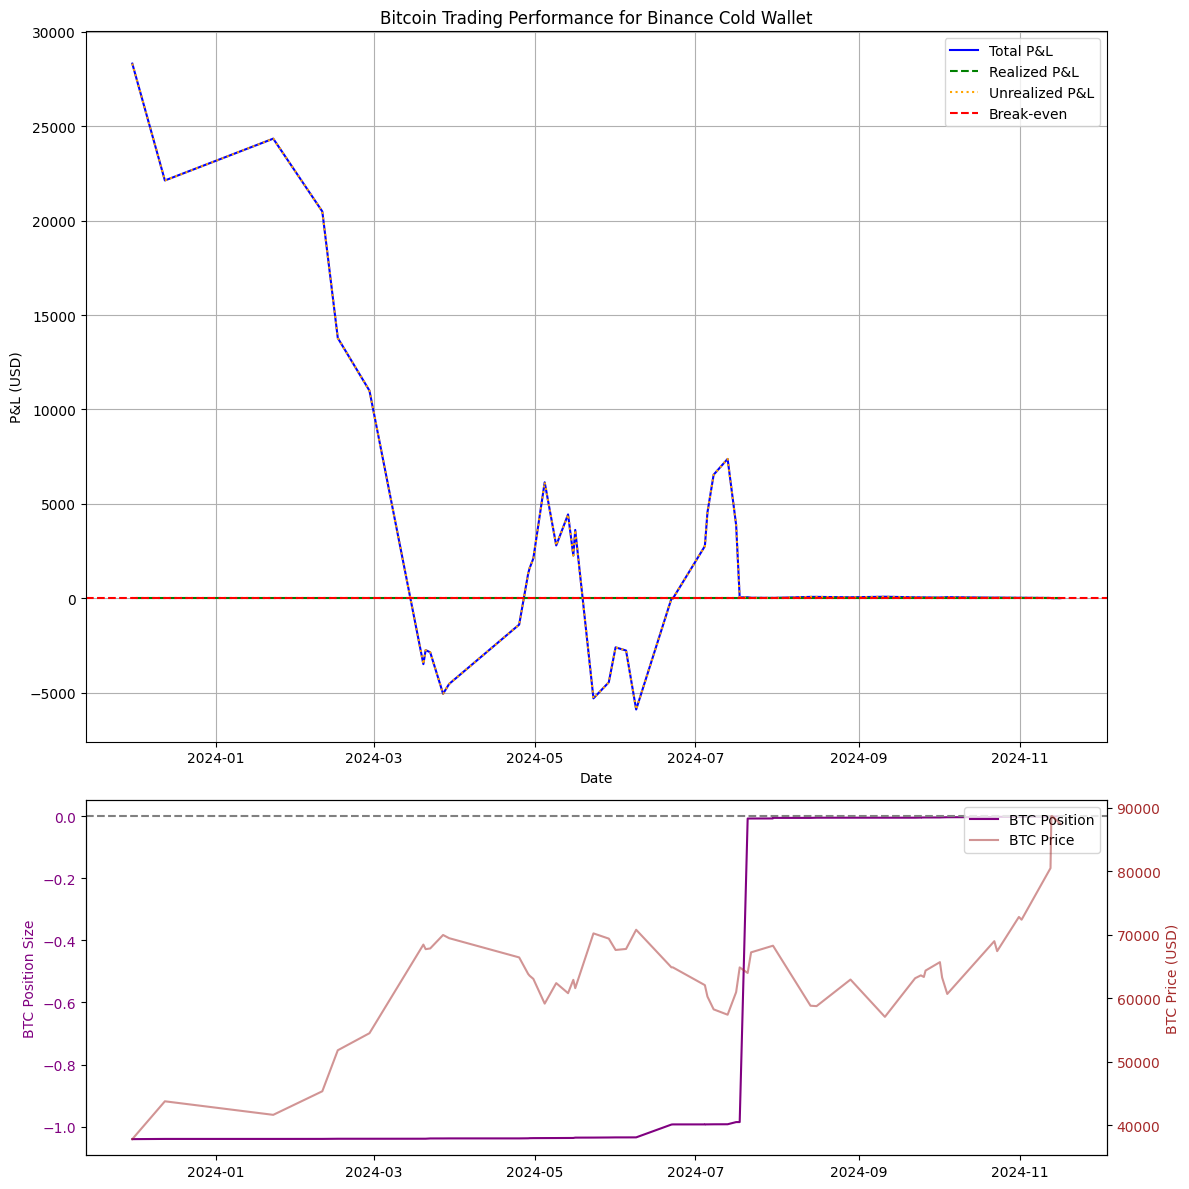

_______________________-------------------------------
No transactions found for Bitfinex Cold Wallet


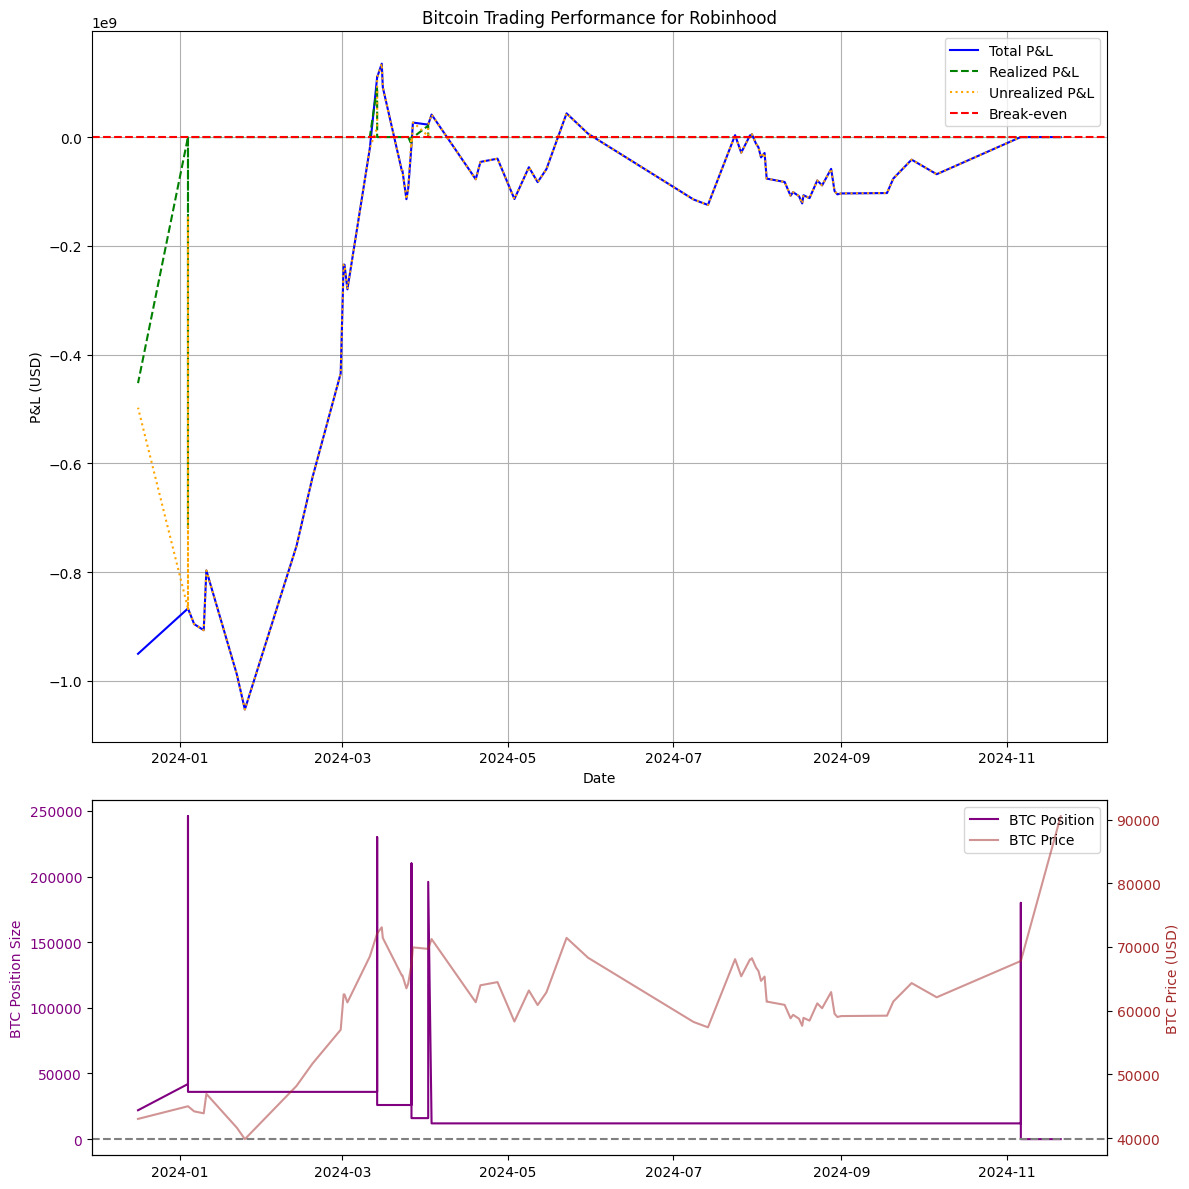

_______________________-------------------------------
No valid transactions to analyze for Coinbase Cold Wallet


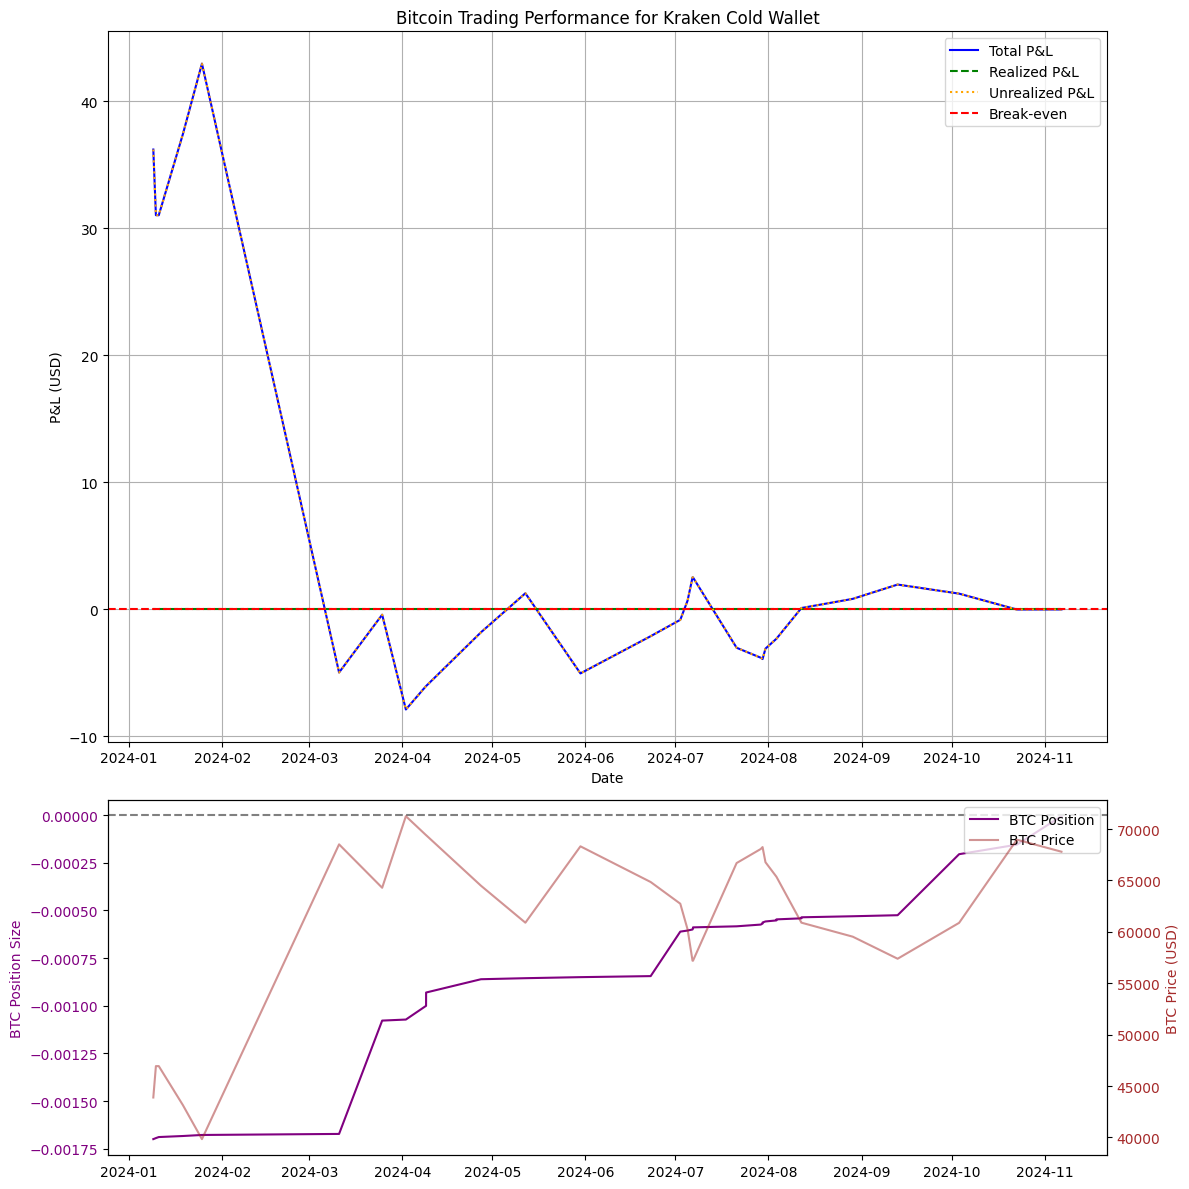

_______________________-------------------------------


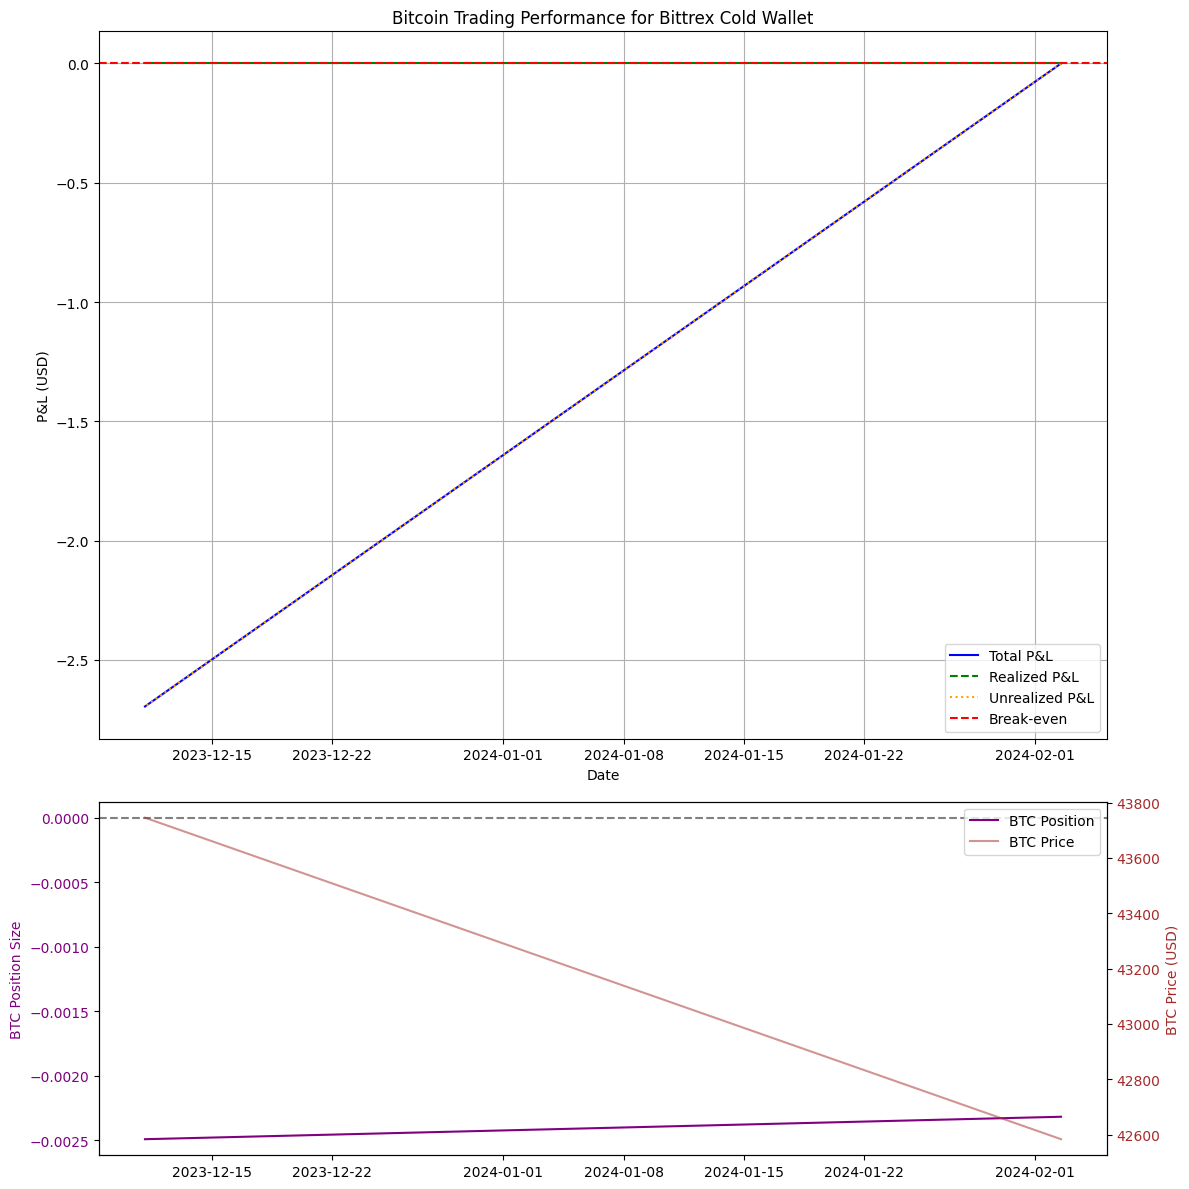

_______________________-------------------------------


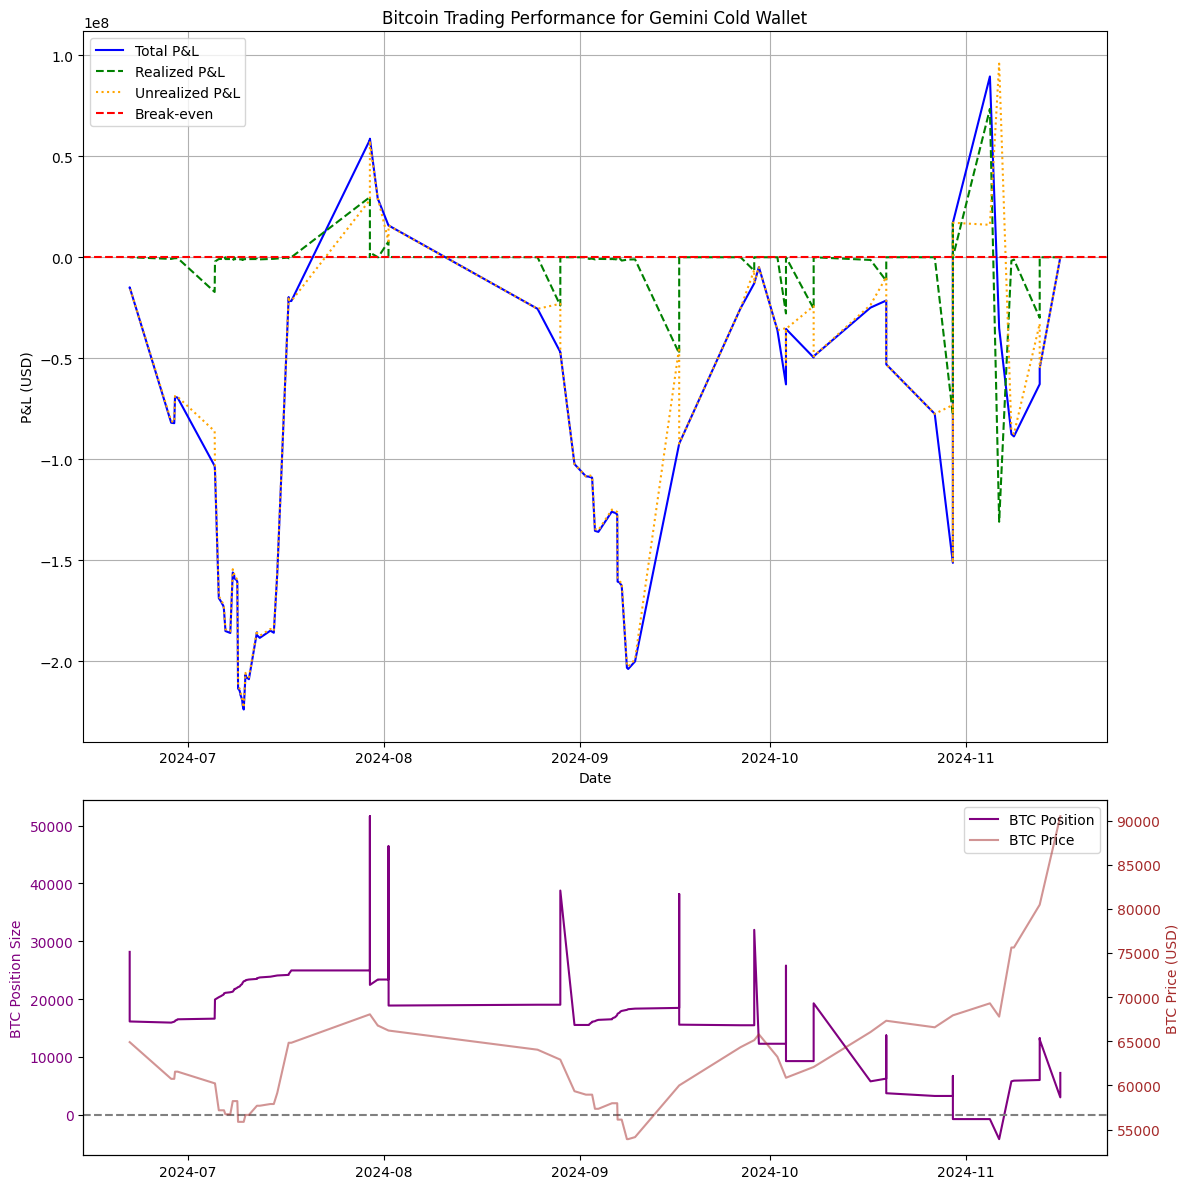

_______________________-------------------------------


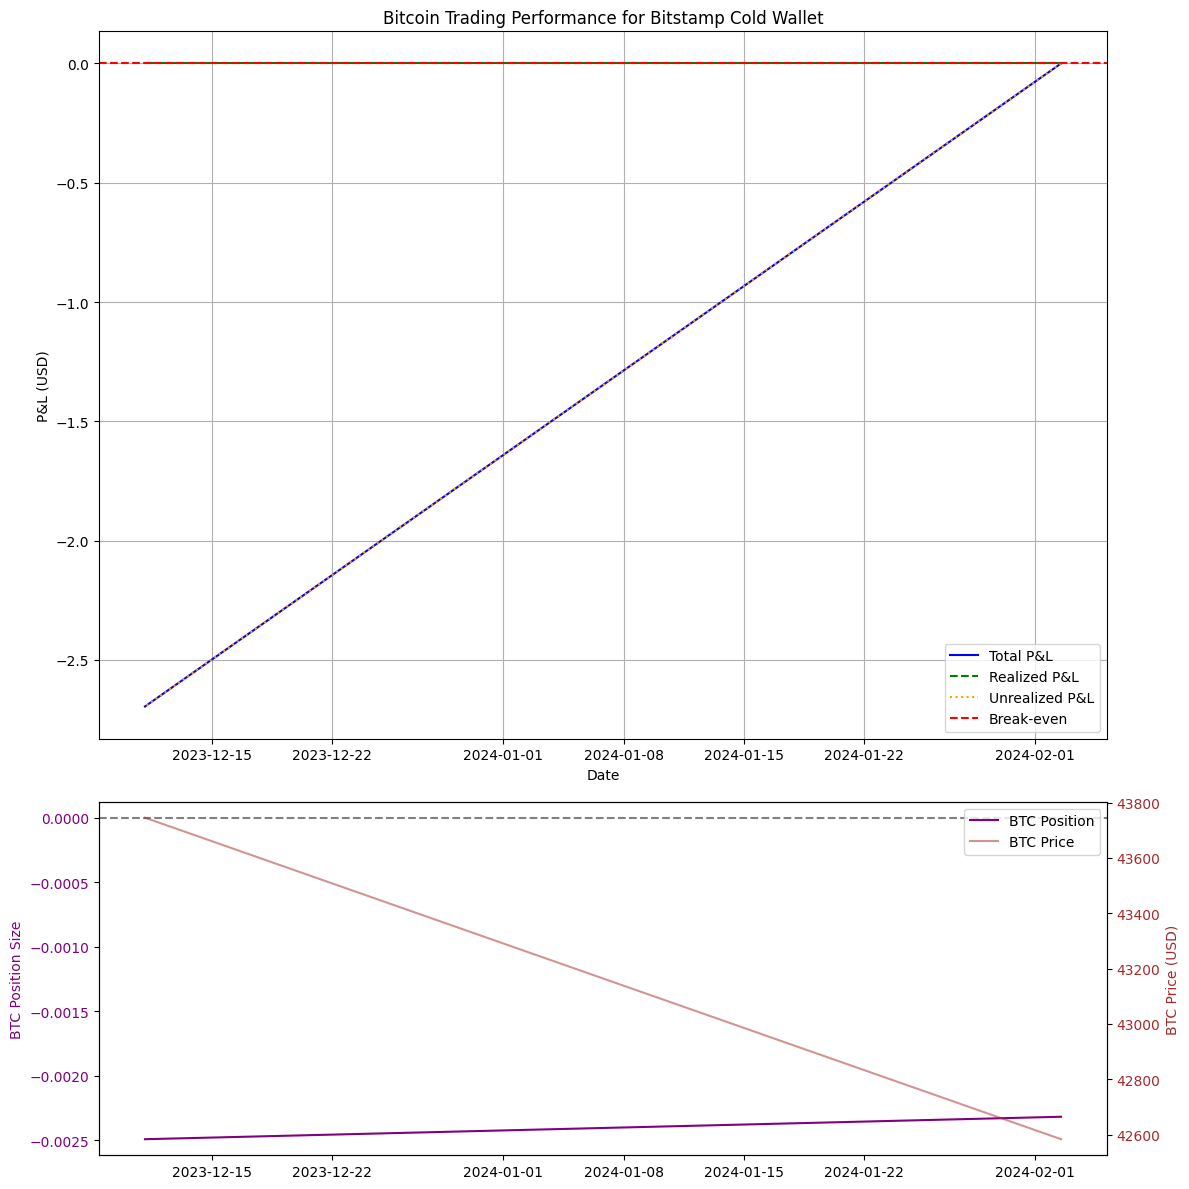

_______________________-------------------------------


In [3]:
!pip install blockcypher

import pandas as pd
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import blockcypher
import time
from dateutil.parser import parse

def get_btc_historical_prices():
    url = 'https://api.coingecko.com/api/v3/coins/bitcoin/market_chart'
    days = 365
    params = {
        'vs_currency': 'usd',
        'days': days
    }

    response = requests.get(url, params=params)
    data = response.json()

    if 'prices' in data:
        prices = data['prices']
    else:
        print("Prices key not found in the response")
        return None

    df = pd.DataFrame(prices, columns=['timestamp', 'price'])
    # Convert to timezone-aware datetime with UTC
    df['date'] = pd.to_datetime(df['timestamp'], unit='ms').dt.tz_localize('UTC')
    df.set_index('date', inplace=True)
    df.drop(columns=['timestamp'], inplace=True)

    return df

def get_transactions(bitcoin_address):
    time.sleep(1)
    address_details = blockcypher.get_address_details(bitcoin_address)
    return address_details.get('txrefs', [])

def calculate_pnl(transactions, btc_prices_df):
    if not transactions:
        return pd.DataFrame()

    btc_position = 0
    cumulative_pnl = []
    position_history = []

    # Convert transaction dates to UTC datetime objects
    for tx in transactions:
        if isinstance(tx['confirmed'], str):
            tx['confirmed'] = parse(tx['confirmed']).replace(tzinfo=None)
        elif tx['confirmed'].tzinfo is not None:
            tx['confirmed'] = tx['confirmed'].replace(tzinfo=None)

    # Remove timezone info from price data index for consistent comparison
    btc_prices_df.index = btc_prices_df.index.tz_localize(None)

    # Create date range without timezone info
    end_date = datetime.today()
    start_date = end_date - timedelta(days=365)

    # Filter transactions within the last 365 days
    transactions = [tx for tx in transactions if start_date <= tx['confirmed'] <= end_date]

    # Reindex price data to cover all dates
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    btc_prices_df = btc_prices_df.reindex(date_range, method='ffill')

    for tx in transactions:
        tx_date = tx['confirmed']
        tx_value_satoshis = tx['value']
        tx_value_btc = tx_value_satoshis / 1e8
        tx_type = 'received' if tx['tx_input_n'] == -1 else 'sent'

        # Get BTC price at transaction time
        try:
            # First try exact match
            tx_btc_price = btc_prices_df.loc[tx_date, 'price']
        except KeyError:
            # If no exact match, get the most recent price before this transaction
            tx_btc_price = btc_prices_df.asof(tx_date)['price']

        tx_value_usd = tx_value_btc * tx_btc_price
        realized_pnl = 0

        if tx_type == 'sent':
            if btc_position < 0:  # Closing/reducing short position
                avg_short_price = sum(p['price'] * p['btc_amount'] for p in position_history) / sum(p['btc_amount'] for p in position_history) if position_history else tx_btc_price
                realized_pnl = (avg_short_price - tx_btc_price) * min(tx_value_btc, abs(btc_position))

                remaining_short = abs(btc_position)
                new_position_history = []
                for pos in position_history:
                    if remaining_short <= 0:
                        break
                    if pos['btc_amount'] <= remaining_short:
                        new_position_history.append(pos)
                        remaining_short -= pos['btc_amount']
                    else:
                        pos_copy = pos.copy()
                        pos_copy['btc_amount'] = remaining_short
                        new_position_history.append(pos_copy)
                        remaining_short = 0
                position_history = new_position_history
            else:  # Opening/increasing long position
                position_history.append({
                    'date': tx_date,
                    'btc_amount': tx_value_btc,
                    'price': tx_btc_price,
                    'type': 'long'
                })

            btc_position += tx_value_btc

        else:  # 'received'
            if btc_position > 0:  # Closing/reducing long position
                avg_buy_price = sum(p['price'] * p['btc_amount'] for p in position_history) / sum(p['btc_amount'] for p in position_history) if position_history else tx_btc_price
                realized_pnl = (tx_btc_price - avg_buy_price) * min(tx_value_btc, btc_position)

                remaining_long = btc_position
                new_position_history = []
                for pos in position_history:
                    if remaining_long <= 0:
                        break
                    if pos['btc_amount'] <= remaining_long:
                        new_position_history.append(pos)
                        remaining_long -= pos['btc_amount']
                    else:
                        pos_copy = pos.copy()
                        pos_copy['btc_amount'] = remaining_long
                        new_position_history.append(pos_copy)
                        remaining_long = 0
                position_history = new_position_history
            else:  # Opening/increasing short position
                position_history.append({
                    'date': tx_date,
                    'btc_amount': tx_value_btc,
                    'price': tx_btc_price,
                    'type': 'short'
                })

            btc_position -= tx_value_btc

        # Calculate unrealized P&L
        unrealized_pnl = 0
        if btc_position != 0 and position_history:
            avg_position_price = sum(p['price'] * p['btc_amount'] for p in position_history) / sum(p['btc_amount'] for p in position_history)
            if btc_position > 0:
                unrealized_pnl = (tx_btc_price - avg_position_price) * btc_position
            else:
                unrealized_pnl = (avg_position_price - tx_btc_price) * abs(btc_position)

        total_pnl = realized_pnl + unrealized_pnl

        cumulative_pnl.append({
            'date': tx_date,
            'realized_pnl': realized_pnl,
            'unrealized_pnl': unrealized_pnl,
            'total_pnl': total_pnl,
            'btc_position': btc_position,
            'position_value': abs(btc_position) * tx_btc_price,
            'btc_price': tx_btc_price
        })

    return pd.DataFrame(cumulative_pnl)

# Main execution
btc_prices_df = get_btc_historical_prices()

if btc_prices_df is not None:
    bitcoin_addresses = [
        {'address': 'bc1qxy2kgdygjrsqtzq2n0yrf2493p83kkfjhx0wlh', 'company': 'Binance Cold Wallet'},
        {'address': 'bc1qw508d6qejxtdg4y5r3zarvary0c5xw7kygt080', 'company': 'Bitfinex Cold Wallet'},
        {'address': 'bc1qgdjqv0av3q56jvd82tkdjpy7gdp9ut8tlqmgrpmv24sq90ecnvqqjwvw97', 'company': 'Robinhood'},
        {'address': '3Cbq7aT1tY8kMxWLbitaG7yT6bPbKChq64', 'company': 'Coinbase Cold Wallet'},
        {'address': '3LYJfcfHPXYJreMsASk2jkn69LWEYKzexb', 'company': 'Kraken Cold Wallet'},
        {'address': '3D2oetdNuZUqQHPJmcMDDHYoqkyNVsFk9r', 'company': 'Bittrex Cold Wallet'},
        {'address': '3JZq4atUahhuA9rLhXLMhhTo133J9rF97j', 'company': 'Gemini Cold Wallet'},
        {'address': '3D2oetdNuZUqQHPJmcMDDHYoqkyNVsFk9r', 'company': 'Bitstamp Cold Wallet'}
    ]

    for entry in bitcoin_addresses:
        bitcoin_address = entry['address']
        company_name = entry['company']

        transactions = get_transactions(bitcoin_address)
        if not transactions:
            print(f"No transactions found for {company_name}")
            continue

        pnl_df = calculate_pnl(transactions, btc_prices_df)
        if pnl_df.empty:
            print(f"No valid transactions to analyze for {company_name}")
            continue

        # Create visualization
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), height_ratios=[2, 1])

        # Plot P&L components
        ax1.plot(pnl_df['date'], pnl_df['total_pnl'], label='Total P&L', color='blue')
        ax1.plot(pnl_df['date'], pnl_df['realized_pnl'], label='Realized P&L', color='green', linestyle='--')
        ax1.plot(pnl_df['date'], pnl_df['unrealized_pnl'], label='Unrealized P&L', color='orange', linestyle=':')
        ax1.axhline(0, color='red', linestyle='--', label='Break-even')
        ax1.set_title(f'Bitcoin Trading Performance for {company_name}')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('P&L (USD)')
        ax1.grid(True)
        ax1.legend()

        # Plot position size and price
        ax2.plot(pnl_df['date'], pnl_df['btc_position'], label='BTC Position', color='purple')
        ax2.set_ylabel('BTC Position Size', color='purple')
        ax2.axhline(0, color='gray', linestyle='--')
        ax2.tick_params(axis='y', labelcolor='purple')

        # Add price overlay
        ax3 = ax2.twinx()
        ax3.plot(pnl_df['date'], pnl_df['btc_price'], label='BTC Price', color='brown', alpha=0.5)
        ax3.set_ylabel('BTC Price (USD)', color='brown')
        ax3.tick_params(axis='y', labelcolor='brown')

        # Add combined legend
        lines1, labels1 = ax2.get_legend_handles_labels()
        lines2, labels2 = ax3.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

        plt.tight_layout()
        plt.show()
        print("_______________________-------------------------------")